## Task 5 - Model development
Develop a model of your choice (i.e., you select the learning task, the target feature, and the input features) and train this model using a library of your choice. Use best practices for training this model and report your training, validation and test scores. Discuss any conclusions you are confident in drawing from this exercise. Is your model ready for production use? Why or why not? 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#import scikitlearn libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import logging


In [3]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

In [4]:
cd = os.getcwd()
parent = os.path.dirname(cd)
data_folder = os.path.join(parent, 'data')

data = pd.read_csv(os.path.join(data_folder, 'dev.csv'))
data
#converting the date column to datetime
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'])

# Extracting components of datetime and making them into their own features. Comment out to test model without datetime features

data['year'] = data['datetime_utc'].dt.year
data['month'] = data['datetime_utc'].dt.month
data['day'] = data['datetime_utc'].dt.day
data['hour'] = data['datetime_utc'].dt.hour
data['minute'] = data['datetime_utc'].dt.minute




**Note: Upon initial training and a check of the feature importance, all of the datetime components were identified as having the largest impact on model performance. I went back to remove them out of curiosity (also because I don't think datetime is that correlated to water surface elev), and the model does not perform as well.**

In [5]:
#remove na values
data.dropna(inplace=True)
data.info()

#identify missing dates in datetime_utc
date_range = pd.date_range(start=data['datetime_utc'].min(), end=data['datetime_utc'].max())
missing_dates = date_range[~date_range.isin(data['datetime_utc'])]
missing_dates

<class 'pandas.core.frame.DataFrame'>
Index: 37014 entries, 0 to 39743
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime_utc     37014 non-null  datetime64[ns]
 1   wtempc           37014 non-null  float64       
 2   atempc           37014 non-null  float64       
 3   winddir_dcfn     37014 non-null  float64       
 4   precp_in         37014 non-null  float64       
 5   relh_pct         37014 non-null  float64       
 6   spc              37014 non-null  float64       
 7   dox_mgl          37014 non-null  float64       
 8   ph               37014 non-null  float64       
 9   windgust_knots   37014 non-null  float64       
 10  wse1988          37014 non-null  float64       
 11  wvel_fps         37014 non-null  float64       
 12  mbars            37014 non-null  float64       
 13  windspeed_knots  37014 non-null  float64       
 14  par              37014 non-null  float64   

DatetimeIndex(['2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03',
               '2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07',
               '2023-03-08', '2023-03-09', '2023-03-10', '2023-03-11',
               '2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23',
               '2023-03-24', '2023-05-09', '2024-01-31'],
              dtype='datetime64[ns]', freq=None)

In [6]:
#target variable should be wse1988
y = data[['datetime_utc', 'wse1988']]
y
X = data.drop(['wse1988'], axis=1)
X

#apply standard scaler to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.iloc[:,1:])
X_scaled
y_scaled = scaler.fit_transform(y.iloc[:,1:])


In [7]:
print(X_scaled)
print(y_scaled)

[[-1.1841078  -0.66996025 -0.92048674 ... -1.55892703 -1.65927382
  -1.34177612]
 [-1.1841078  -0.72201307 -1.30063069 ... -1.55892703 -1.65927382
  -0.44729093]
 [-1.1841078  -0.74283419  0.28647032 ... -1.55892703 -1.65927382
   0.44719426]
 ...
 [-1.16180014 -1.34664684 -1.2055947  ...  0.37809708  1.65732591
  -0.44729093]
 [-1.16180014 -1.36746797 -0.99651553 ...  0.37809708  1.65732591
   0.44719426]
 [-1.17295397 -1.38828909 -1.00601913 ...  0.37809708  1.65732591
   1.34167946]]
[[-1.03772167]
 [-1.10469332]
 [-1.15105831]
 ...
 [-1.53743322]
 [-1.62501153]
 [-1.71258984]]


In [8]:
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train


array([[-1.12833866, -0.22230605,  1.70250655, ..., -0.19161589,
         1.08052596, -1.34177612],
       [-0.10218647, -0.15984267,  0.24845592, ..., -1.55892703,
         0.07112604, -0.44729093],
       [ 0.9574272 ,  0.71464461,  0.13441274, ..., -0.76132887,
         0.503726  ,  1.34167946],
       ...,
       [ 0.64512001,  0.72505518, -1.32914149, ...,  1.06175264,
         1.22472594,  0.44719426],
       [-1.09487717, -1.07597221, -1.41467388, ..., -0.64738627,
         1.65732591, -1.34177612],
       [ 1.2362729 ,  1.77652203,  0.23895232, ..., -0.41950108,
        -1.65927382, -1.34177612]])

In [9]:
#create a dataframe for the training and testing sets
X_train = pd.DataFrame(X_train, columns=X.columns[1:])
X_test = pd.DataFrame(X_test, columns=X.columns[1:])
y_train = pd.DataFrame(y_train, columns=y.columns[1:])
y_test = pd.DataFrame(y_test, columns=y.columns[1:])
y_train

,wse1988
0,-0.434977
1,0.579901
2,0.183223
3,-0.718318
4,0.646873
...,...
29606,0.935366
29607,1.234163
29608,-2.454430
29609,1.110523


In [10]:
# initialize FNN model (sequential model). only 2 hidden layers with typical shape

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(64, activation='relu'),             # Hidden layer 1 with 64 neurons
    layers.Dense(32, activation='relu'),             # Hidden layer 2 with 32 neurons
    layers.Dense(1)                                  # Output layer (regression problem, so no activation)
])

Epoch 1/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.9328 - val_loss: 0.8016
Epoch 2/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8078 - val_loss: 0.7402
Epoch 3/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7285 - val_loss: 0.6895
Epoch 4/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - loss: 0.6812 - val_loss: 0.6569
Epoch 5/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6550 - val_loss: 0.6486
Epoch 6/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6191 - val_loss: 0.6310
Epoch 7/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6024 - val_loss: 0.6162
Epoch 8/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5905 - val_loss: 0.6163
Epoch 9/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5640 - val_loss: 0.5933
Epoch 10/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5492 - val_loss: 0.5948
Epoch 11/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5383 - val_loss: 0.5685
Epoch 12/40
741/741 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/st

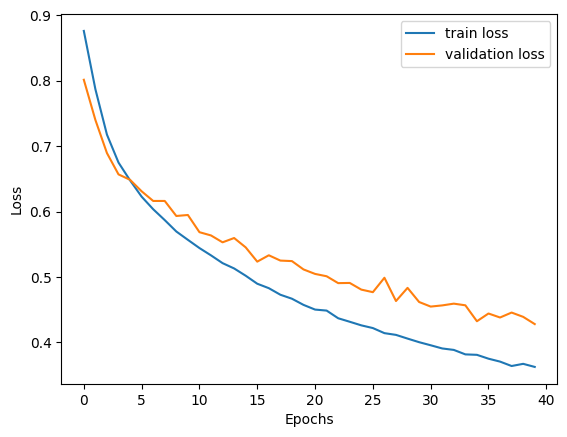

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

# train model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=32, verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4183
Test Loss: 0.42306050658226013
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


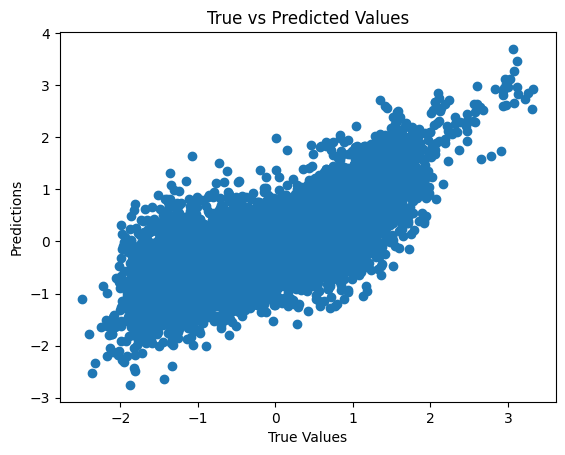

In [12]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(X_test)

# plot predictions vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

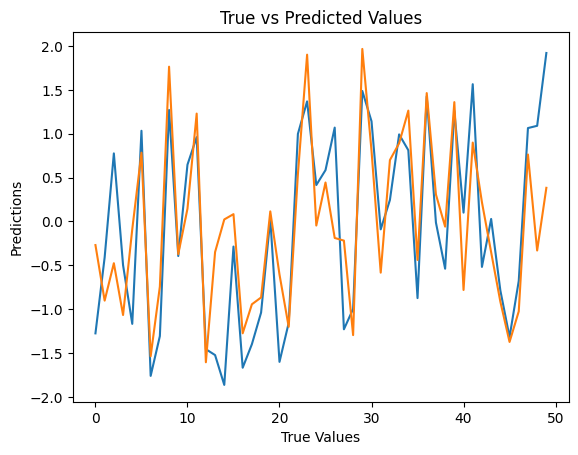

In [13]:
#plotting y_test and y_pred as a line plots together
plt.plot(y_test[:50])
plt.plot(y_pred[:50])
plt.xlabel('True Values')  
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error

def mse_score(model, X, y):
    y_pred = model.predict(X)
    return -mean_squared_error(y, y_pred)

In [15]:
from sklearn.inspection import permutation_importance

# predict test set with trained model
y_pred = model.predict(X_test)

# caclulate importance. 10 permutations per feature, use custom scoring function
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring=mse_score)

# print the importance
for i in result.importances_mean.argsort()[::-1]:
    print(f"Feature {X.columns[i]}: {result.importances_mean[i]:.4f}")


232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
232/232 ━━━━━━━━━━━━━━━━━